In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns 

In [4]:
import numpy as np
from tailnflows.utils import load_raw_data, load_experiment_output_data


experiment_output = load_experiment_output_data('sp500/2025-01-tst')

rows = []
for model, run_datas in experiment_output.items():
    for rd in run_datas:
        rows.append({
            'data': model.split('-')[0],
            **rd
        })

df = pd.DataFrame(rows)

grouper = ['model', 'depth']

selector = np.ones(len(df), dtype=bool)
# selector &= df['batch_size'] == 100
# selector &= df['tail_bound'] == 2.5
# selector = np.logical_and(
#     df['batch_size'] == 100,
#     df['tail_bound'] == 2.5
# )
df = df[selector]

grouped = df.groupby(grouper)
agg = grouped[['val_ll', 'tst_ll']].agg(['mean', 'sem', 'std'])
# agg['p1'] = agg['mean'] + agg['sem']
best = agg['tst_ll'].sort_values(by='mean')
within = best.iloc[0]['mean'] + best.iloc[0]['std']

def highlight_by_mean(row, threshold=7):
    """
    Highlight the row if the 'Mean' value is above the given threshold.
    """
    if row['mean'] < threshold:
        # Highlight entire row in a light green
        return ['background-color: #dfffdf'] * len(row)
    else:
        # No highlight
        return ['background-color: white'] * len(row)
    
best.style.apply(
    highlight_by_mean, 
    axis=1, 
    threshold=within
)

,mean,sem,std
model,,,
ttf_fix,294.304596,nan,nan
gtaf,301.901733,nan,nan
ttf,305.204712,nan,nan
normal,305.295105,nan,nan
comet,324.381769,0.182739,0.577872


In [5]:
from matplotlib.patches import Patch

color_palette = plt.get_cmap('tab10', len(agg.index))  # Using a colormap

model_to_color = {model: color_palette(i) for i, model in enumerate(agg.index)}

selected_ix = []
for ix, group in grouped:
    plt.scatter(group.val_ll, group.tst_ll, color=model_to_color[ix], marker='.')
    # plt.scatter(ix[-2], group.tst_ll, c=model_to_color[ix])
    selected_ix.append(ix)

plt.ylabel('tst')
plt.xlabel('val')
legend_elements = [Patch(facecolor=model_to_color[model], edgecolor='black', label=model) 
                   for model in selected_ix]
plt.legend(handles=legend_elements, title="Models", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()

KeyError: ('comet',)

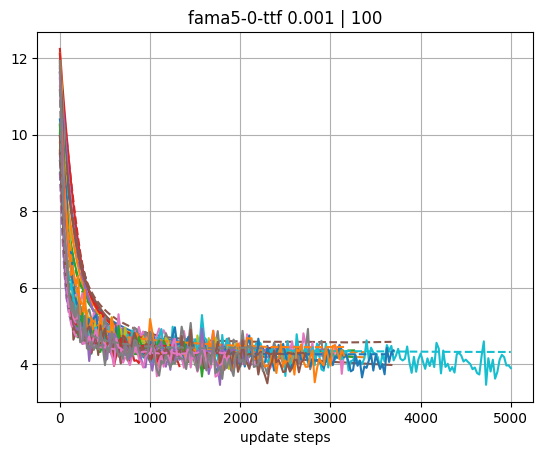

In [6]:
ttf_runs = load_experiment_output_data('fama5/2025-01-optim')

# load_raw_data()
for label, runs in ttf_runs.items():
    for run in runs:
        losses = load_raw_data(run['loss_path'])[label][
            run['loss_ix']
        ]

        plt.title(f'{label} {run["lr"]} | {run["batch_size"]}')
        l, = plt.plot(losses['steps'], losses['losses'], label='')
        plt.plot(losses['steps'], losses['vlosses'], linestyle='--', c=l.get_color())
        plt.xlabel('update steps')
    # plt.ylim([0, 500])
    plt.grid()
    plt.show()

In [56]:
import pickle
tail_path = '/home/th17628/tailnflows/rough_work/climdex_tails.pkl'
with open(tail_path, 'rb') as f:
    marginal_dfs = pickle.load(f)


In [ ]:
from pathlib import Path
from tailnflows.utils import get_data_path

data_source = "sp500"
tail_path = f'{get_data_path()}/splits/{data_source}/{split}'
if not Path(f"{tail_path}.p").is_file():
    raise Exception(
        f"Split data not present at {tail_path}.p, either configure "
        "TAILNFLOWS_DATA_DIR, or run `python experiments/density_estimation_real_data/generate_splits.py`"
    )
    
splits_and_tail = load_raw_data(tail_path)["experiment_data"][0]

In [3]:
rows = [
    {
        'model': label.split(' ')[0],
        **data
    }
    for label, experiments in raw_data.items()
    for data in experiments
]
# rows += [
#     {
#         'model': label.split(' ')[0]+ '_b8',
#         **data
#     }
#     for label, experiments in raw_data_2.items()
#     for data in experiments
# ]
# rows += [
#     {
#         'model': label.split(' ')[0]+ '_sinit',
#         **data
#     }
#     for label, experiments in raw_data_3.items()
#     for data in experiments
# ]
# rows += [
#     {
#         'model': label.split(' ')[0]+ '_d2',
#         **data
#     }
#     for label, experiments in raw_data_4.items()
#     for data in experiments
# ]

df = pd.DataFrame(rows)
df['test_neg_ll_per_dim'] = df['tst_neg_ll'] / df['dim']
df.head()
name_map = {
    'ttf_aff_u': 'TTF',
    'ttf_fix_aff_u': 'TTF (fix)',
    'mtaf': 'mTAF',
    'gtaf': 'gTAF',
}
df['readable_name'] = df['model'].apply(lambda x: name_map.get(x, x))

In [4]:
df.groupby('readable_name').count()

,model,dim,seed,tst_neg_ll,test_neg_ll_per_dim
readable_name,,,,,
TTF,30,30,30,30,30
TTF (fix),30,30,30,30,30
gTAF,30,30,30,30,30
mTAF,30,30,30,30,30
ttf,10,10,10,10,10
ttf_aff,10,10,10,10,10
ttf_fix,10,10,10,10,10
ttf_fix_aff,10,10,10,10,10


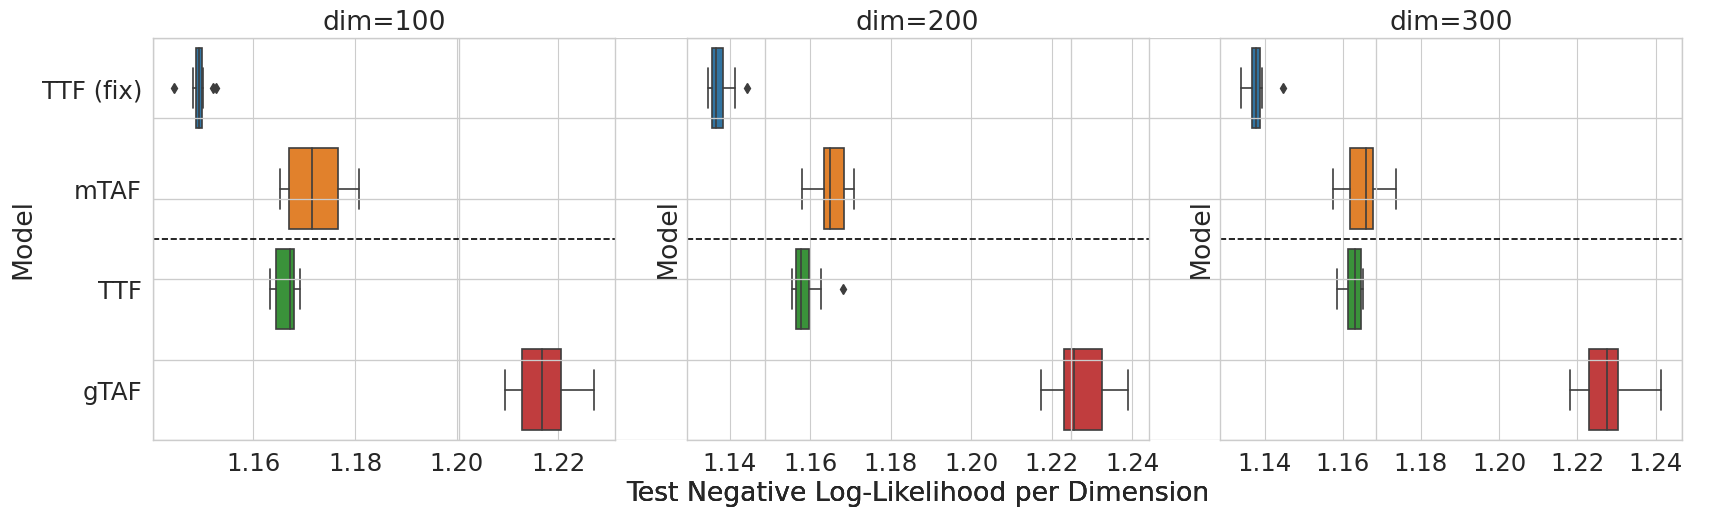

In [18]:
target_dims = [100, 200, 300]
fig, axarr = plt.subplots(1, len(target_dims), figsize=(18, 6), tight_layout=True, sharey=True)
if len(target_dims) == 1:
  axarr = [axarr]

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.)

for i, dim in enumerate(target_dims):
  j = 1

  wanted_data = df[df['dim'] == dim]

  sns.boxplot(
      data=wanted_data,
      x='test_neg_ll_per_dim',
      y='readable_name',
      order=['TTF (fix)', 'mTAF', 'TTF', 'gTAF'],
      orient='h',
      ax=axarr[i],
  )

  axarr[i].axhline(1.5, linestyle='--', c='black')
  axarr[i].set_title(f'dim={dim}')
  axarr[i].set_xlabel('')
  axarr[i].set_ylabel('Model')

  fig.add_subplot(111, frameon=False)
  plt.xlabel('Test Negative Log-Likelihood per Dimension')
  plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
  plt.tight_layout()
  plt.savefig(f"./real_sp500.png")

In [ ]:
proc_data = []
for label, fit_data in raw_data.items():
  for (test_ll, dim) in fit_data:
    if label in models:
      plot_label = models[label]
      proc_data.append({'model': plot_label, 'test_neg_ll': test_ll, 'dim': dim})

df = pd.DataFrame(proc_data)

In [4]:
rd_path =  f'../../experiment_output/returns_2024-01-31.p'
rd_path2 =  f'../../experiment_output/returns_2024-02-08.p'

raw_data = pickle.load( open(rd_path, "rb" ) )
raw_data2 = pickle.load( open(rd_path2, "rb" ) )

raw_data['TTF_m_fix_new'] = raw_data2['TTF_m_fix']
raw_data['TTF_m_stable'] = raw_data2['TTF_m_stable']
raw_data['TTF_m_affine_stable'] = raw_data2['TTF_m_affine_stable_longer+']
raw_data['TTF_m_affine_fix'] = raw_data2['TTF_m_affine_fixed_longer+']
raw_data['TTF_m_affine_stable_new'] = raw_data2['TTF_m_affine_stable__new']
raw_data['TTF_m_affine_fix_new'] = raw_data2['TTF_m_affine_fixed_new']

FileNotFoundError: [Errno 2] No such file or directory: '../../experiment_output/returns_2024-01-31.p'

In [ ]:
models = {
    # 'gTAF': 'gTAF',
    # 'TTF_m_init_-0,5->1,5': 'TTF',
    'mTAF': 'mTAF',
    # 'TTF_m_fix': 'TTF (fix)',
    # 'TTF_m_fix_new': 'TTF (fix)',
    'TTF_m_stable': 'TTF',
    # 'TTF_m_affine_stable': 'TTF aff',
    # 'TTF_m_affine_stable_new': 'TTF + affine',
    # 'TTF_m_affine_fix': 'TTF aff (fix)',
    # 'TTF_m_affine_fix_new': 'TTF + afffine (fix)',
}

In [5]:

df.test_neg_ll = df.test_neg_ll.astype('float')
target_dims = list(df.dim.unique())
target_dims = [100]
fig, axarr = plt.subplots(1, len(target_dims), figsize=(12, 6), tight_layout=True)
if len(target_dims) == 1:
  axarr = [axarr]

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.)

for i, dim in enumerate(target_dims):
  j = 1

  wanted_data = df[df['dim'] == dim]

  sns.boxplot(
      data=wanted_data,
      x='test_neg_ll',
      y='model',
      order=models.values(),
      orient='h',
      ax=axarr[i],
  )

  axarr[i].set_title(f'dim={dim}')
  plt.tight_layout()
  plt.savefig(f"../../../ftfnf_writeup/graphics/real_sp500_dim_100_new.png")

NameError: name 'raw_data' is not defined